<a href="https://colab.research.google.com/github/sri-go/BigDataAnalytics/blob/master/PCA_Random_Forest_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Homework 4: Amazon Review Analysis and Classification

Your main training set for this assignment is the text from 100,000 reviews from Amazon.com, their timestamps, and their star ratings. The high level goal of this homework is to use the textual and temporal data to predict the star ratings.

**Adventurers beware!** Analyzing this data in `sklearn` will likely kill your kernel because it may need to store 1.9 billion values. So instead we will use the package [gensim](https://radimrehurek.com/gensim/) for analysis. gensim specializes in efficient implementations of common modeling techniques for big text.

In [0]:
# install stuff
%%capture
!pip install -U gensim
!pip install urllib2

Make sure the following line prints the up-to-date version of `gensim`, which at time of releasing this homework was version 3.8.1. If not, run the cell above again. If you don't do this, you may get different answers than us or have annoying error messages.

In [0]:
# check gensim version
import gensim
gensim.__version__

'3.8.1'

In [0]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from datetime import *
from operator import itemgetter


In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [0]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

## Step 0: Explore the format

We will start with exploring the format of all of the data files that we imported above. 

### Step 0.1: gensim dictionary (lexicon)

Most data science over text has some form of vocabulary. Simply put, you need to decide which words your model will care about. Very rare words, misspellings, numbers, and urls are good candidates for exclusion, especially since if the model needs any form of normalization, the time complexity of such computations is at least linear in the size of the vocabulary, if not worse.

A lexicon associates each word in the vocabulary with an index. Since words are repeated, the model can save space by using the index for every repetition and only linking the index with the string form once. A `gensim` dictionary is special in that it is very fast and allows bidirectional lookups, namely, word to index and index to word.

After reviewing the [documentation](https://radimrehurek.com/gensim/corpora/dictionary.html), rewrite the right hand side of each line in the cell below with the answers to these questions.

1. In the `gensim` dictionary `reviews_dict`, what is the index of "best"? Look it up and store it in a variable named `best`. To clarify, if you find that 42 is the index of "best", change the line below so that it sets `best` equal to 42. Of course, you can do this with `best = 42` and earn full points, but it is a litte better to reuse the command with which you found the index. For example, if the `gensim` dictionary worked like a list of strings, you could do it with  
`best = reviews_dict.iloc('best')`.
2. What word belongs to index 1911? Look it up and store it in a variable named `onenineoneone`.
3. What happens when you evaluate `reviews_dict[i]` for some variable `i`? If this returns the word associated with that index, set `idx2word` to `True`. Otherwise, set it to `False`. For example, if `reviews_dict['best']` equals `best`, `idx2word` should be `False`, but if `reviews_dict[1911]` equals `onenineoneone`, `idx2word` should be `True`.

Hint: `token2id('best')` and `id2token(1911)` didn't work for me either. Keep trying!

In [0]:
# answer 0.1
best = reviews_dict.token2id['best']
onenineoneone = list(reviews_dict.token2id.keys())[list(reviews_dict.token2id.values()).index(1911)]
idx2word = True

### Step 0.2: Look up individual reviews

`gensim` represents everything in a **sparse** way. Namely, the representation of a review will be a variable-size list that contains counts of the words that _are present_ in the review. A **dense** representation, on the other hand, such as a matrix, would, in addition to the present words, contain zero counts for all of the words that are not in that particular review. For some examples, see [this tutorial](https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html).

But the optimizations don't stop there! `gensim` also saves space by not directly storing where one document ends and another begins. Such an implementation decision encourages users to stream the dataset through the user's pipeline, rather than attempt to read large chunks into memory. Put another way, you can iterate through the dataset using a loop or vectorized function, but you cannot index. In code:

`for doc in corpus` works!

`corpus[1911]` does not work!

On some occasions, though, it would be convenient for us to, say, look up the 1911th document directly.

So let's implement a function that iterates through the `gensim` `corpus`, collects every document whose index appears in `indices`, and returns that list of documents (subset of the dataset). For example, say we want the documents with the following indices: `indices = [0, 19, 11, 0]`. Then `lookup_docs` should return the 1st, 12th, and 20th documents, in that order.

To emphasize, if an index appears multiple times in `indices`, just return one copy. And for consistency with our autograder, please return the documents in order of increasing index. That would be be like `corpus[0]`, then `corpus[11]`, then `corpus[19]` in our example. Of course, that way to reference them doesn't work, though!

In [0]:
# answer 0.2 
# TODO: Complete the function
def lookup_docs(corpus, indices):
    temp_list = []
    #return document at index
    for i, document in enumerate(corpus):
        if i in indices:
          temp_list.append(document)
    return temp_list

Once you have written `lookup_docs`, you may run the cell below (no modification needed) to see how documents are represented in a gensim [corpus](https://radimrehurek.com/gensim/corpora/mmcorpus.html). In each review, `gensim` stores a tuple of size 2 for each distinct word in the review. The first number in the tuple is the index of the word in the dictionary and the second number in the tuple is the count of the times that word appeared in that review.

In [0]:
indices = [10,18]
docs = lookup_docs(reviews_bow, indices)
print(docs[0])
print(docs[1])

[(2, 1.0), (21, 1.0), (23, 1.0), (55, 1.0), (72, 1.0), (79, 1.0), (108, 1.0), (121, 1.0), (138, 1.0), (144, 1.0), (176, 1.0), (238, 1.0), (258, 1.0), (266, 3.0), (267, 1.0), (268, 2.0), (269, 1.0), (270, 1.0), (271, 1.0), (272, 3.0), (273, 1.0), (274, 1.0), (275, 1.0), (276, 1.0), (277, 1.0), (278, 2.0), (279, 1.0), (280, 1.0), (281, 1.0), (282, 1.0)]
[(5, 1.0), (11, 2.0), (14, 2.0), (17, 1.0), (24, 7.0), (30, 2.0), (31, 1.0), (49, 1.0), (50, 2.0), (51, 1.0), (60, 1.0), (71, 2.0), (82, 1.0), (87, 2.0), (105, 3.0), (144, 2.0), (164, 1.0), (165, 1.0), (177, 1.0), (179, 1.0), (181, 1.0), (186, 1.0), (218, 4.0), (224, 1.0), (233, 1.0), (241, 1.0), (258, 1.0), (348, 1.0), (373, 1.0), (379, 1.0), (382, 1.0), (383, 2.0), (384, 1.0), (385, 2.0), (386, 1.0), (387, 3.0), (388, 1.0), (389, 1.0), (390, 2.0), (391, 1.0), (392, 1.0), (393, 1.0), (394, 1.0), (395, 1.0), (396, 1.0), (397, 1.0), (398, 1.0), (399, 1.0)]


### Step 0.3: Make reviews more human-readable

Now, we would like you to write a function that takes a `gensim` bag of words document and its corresponding dictionary as input and returns a "translated" version that is more readable. The reviews are already represented as bags of words, so recall that you cannot recover the order of the words in the reviews. But, we would like you to spell out the repeats of each word. So, if the original review were "to be or not to be", `reviews_bow` would have something like:

`[(0, 2.0), (1, 1.0), (2, 1.0), (3, 2.0)]`

and we would like you to return the string

`"be be not or to to"`

In [0]:
# answer 0.3
# TODO: Complete the function
def translate_review(review, reviews_dict):
    temp_string = ""
    i = 0
    for index, count in review:
      i = 0
      while i < count:
        temp_string += reviews_dict[index] + " "
        i += 1
    return temp_string

readable_1 = translate_review(docs[0], reviews_dict)
print(readable_1)

readable_2 = translate_review(docs[1], reviews_dict)
print(readable_2)

also hard just will replac use pet anyth time go stop want product cat cat cat cooler cut cut describ found groomer hair hair hair hot long need never poor shave shave shed summer though weather 
away chewer chewer destroy destroy fast kong kong kong kong kong kong kong mix mix money tore toy toy tri dog regular regular worth bought bought one one one go go fine first take within chew rip like like like like probabl thing care product look two pound big bone bone chase dachshund dachshund durabl extrem extrem extrem five flyer frisbe frisbe habit mine minut power pretti realli sure version wobbler 


### Step 0.4: Parse review times

It might be useful in predicting the scores of the reviews to know when the reviews were written. In this dataset, the day of the review was recorded as the number of seconds that passed between midnight on January 1, 1970 (the beginning of time for many computer systems) and the time the review was created. This may be efficient because it is one integer, but it is not very convenient. So we are going to convert these int objects to [datetime](https://docs.python.org/3/library/datetime.html) objects:

**Do not change `review_times` in any way. Work with other variables instead.**

#### Step 0.4.1: Convert times vector

The `convert_times` function should take in the entire `review_times` vector at once. It should return a new pandas `Series` object made from `review_times` but the entries should be of type `datetime` or `Timestamp`.

Hint: You might find `datetime.fromtimestamp` to be useful.

In [0]:
# answer 0.4.1
# TODO: Complete the function
def convert_times(reviews_times):
    converted_time = []
    for time in reviews_times:
        converted_time.append(datetime.fromtimestamp(time))

    converted_time = pd.Series(converted_time)
    return converted_time

In [0]:
converted_times = convert_times(reviews_times)
print("converted_times is a", type(converted_times))

converted_times is a <class 'pandas.core.series.Series'>


#### Step 0.4.2: Time math

The `days_before` function should take in one time value (after applying `convert_times`) and return a new time value that is exactly `offset` days before the input.

Hint: You might find `timedelta` to be useful.

In [0]:
# answer 0.4.2
# TODO: Complete the function
def days_before(time_item, offset):
    offset_time = time_item - timedelta(offset)
    return offset_time   

In [0]:
display(converted_times[0])
forty_days_before_review_times_0 = days_before(converted_times[0], 40)
display(forty_days_before_review_times_0)

Timestamp('2012-05-06 00:00:00')

Timestamp('2012-03-27 00:00:00')

## Step 1: How many components?

We will need to perform dimesionality reduction on our dataset before we can proceed further with the supervised task of predicting the star ratings. One of the greatest benefits of gensim is that it can decompose a sparse dataset directly. Indeed, they post some impressive numbers about their SVD speed [here](https://radimrehurek.com/gensim/models/lsimodel.html).

### Step 1.1: PCA on raw counts

We are first going to choose too many components deliberately, just to make sure that we see the whole picture. But note that 1000 components would still require us to store 100 million numbers. So that is probably too big for convenient exploration of the dataset.

#### Step 1.1.1: Train the PCA model

Train a gensim `LsiModel` on `reviews_bow` using `reviews_dict` as the dictionary and 1000 components. This magic number is provided as `max_cutoff`. The API is [here](https://radimrehurek.com/gensim/models/lsimodel.html).

**This step took about 4 minutes for my Colab instance to complete.**

In [0]:
# answer 1.1.1
# TODO: Learn the syntax of the LsiModel command
max_cutoff = 1000
# TODO #
model = LsiModel(reviews_bow, id2word=reviews_dict, num_topics=max_cutoff)

In [0]:
print('Number of unique tokens: %d' % len(reviews_dict))
print('Number of documents: %d' % len(reviews_bow))

Number of unique tokens: 18716
Number of documents: 100000


#### Step 1.1.2: Extract the singular values

Look at the [API page](https://radimrehurek.com/gensim/models/lsimodel.html) to figure out how to get the singular values from a trained model. Feed those and `max_cutoff` to the `plot_variance_vs_components` function, which you do not have to edit.

In [0]:
def plot_variance_vs_components(singular_values, cutoff):
    evr = np.array([singular_values[i]**2 / sum(singular_values**2) for i in range(cutoff)])
    var = np.cumsum(evr*100)
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Components')
    plt.title('PCA Analysis')
    plt.style.context('seaborn-whitegrid')
    plt.plot(var)

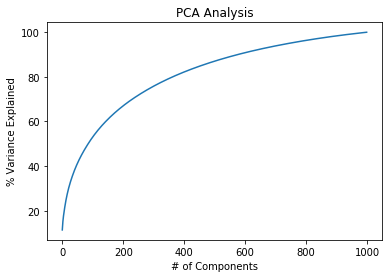

In [0]:
# answer 1.1.2
# TODO: Plot variance versus number of components
# TODO #
singular_values = model.projection.s
plot_variance_vs_components(singular_values, max_cutoff)

The good news is this curve is very steep in the beginning, which shows that a lot of information is conveyed in the first components. However, there is no plateau that we can use to choose a cutoff!

**So, let's go back to the dataset. Are the numbers in `reviews_bow` distributed sensibly?**

### Step 1.2: TF-IDF -- a better distribution

The function below allows us to visualize the distribution of the values in the bag of words. You do not need to edit it. Recall that there are no zero values by nature of the sparse representation. The function has two convenient features:

1. It allows you to transform the values uniformly using an optional second argument.
2. By subtracting the mean, the new mean will line up with $x=0$.

In [0]:
def plot_values(reviews, function=None):
    values = []
    for doc in reviews:
        for (word, score) in doc:
            if not function: values.append(score)
            else:            values.append(function(score))

    plt.hist(values - np.mean(values), bins='auto')
    plt.show()

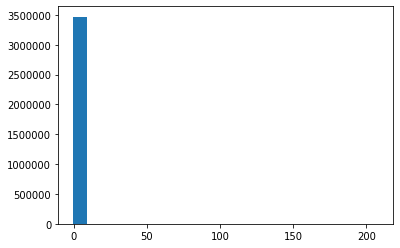

In [0]:
plot_values(reviews_bow)

It appears that our values are very highly skewed. Therefore, minmax and standard scaling would not (yet) be appropriate. Let's see if we can make it look better by log scaling the values:

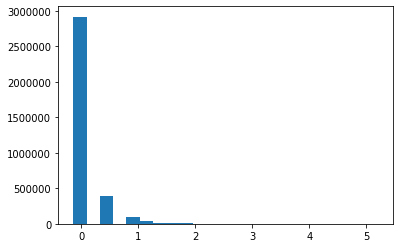

In [0]:
plot_values(reviews_bow, np.log)

It is a little better, but only a little bit. Perhaps a double log?

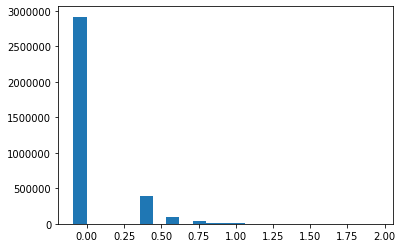

In [0]:
plot_values(reviews_bow, lambda x: np.log(np.log(x+1)))

Still not so good. There are (at least) two outstanding issues with this distribution:

1. The vast majority of words only occur once per review.
2. In the rare case that a word occurs more than once, we can't tell if that is because it is especially important or because it is a common word, like a stop word.

Therefore, we are going to convert our counts into [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) scores. Luckily, this is built in to `gensim` so this can be done in a couple lines of code. The API is [here](https://radimrehurek.com/gensim/models/tfidfmodel.html). Complete the function below that converts the data to TF-IDF scores. Note: that is a two step process. First, you need to initialize and fit a TF-IDF model to `reviews_bow`. (use default values for all hyperparameters **EXCEPT you should set `normalize=True`**). Then, you should apply your TF-IDF model to `reviews_bow` to transform it. Return the new version of the dataset.

In [0]:
# answer 1.2
# TODO: Complete the function
def make_tfidf(reviews_bow):
    model = TfidfModel(reviews_bow, normalize=True)
    apply = model[reviews_bow]
    return apply

In [0]:
reviews_tfidf = make_tfidf(reviews_bow)

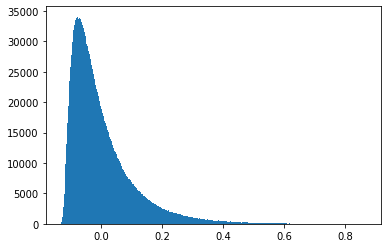

In [0]:
plot_values(reviews_tfidf)

This should look a lot better. Log scaling it may make the distribution look a bit more symmetrical, but this would come at the cost of collapsing some distinctions in the right tail, so we will not do it.

### Step 1.3: PCA on TF-IDF scores

Let's try the PCA again and plot a new variance versus number of components.

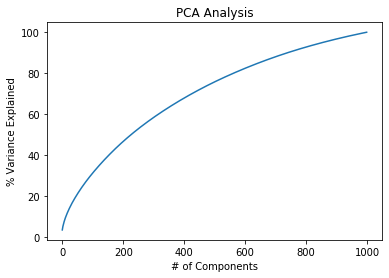

In [0]:
# answer 1.3
# TODO: Train an LsiModel and run the plot_variance_vs_components function
# TODO #
max_cutoff = 1000
model = LsiModel(reviews_tfidf, id2word=reviews_dict, num_topics=max_cutoff)

plot_variance_vs_components(singular_values=model.projection.s, cutoff=max_cutoff)

If anything, this graph is less helpful than before. **So, instead, we would like to use downstream performance of the classifier to tune this hyperparameter.** So let's build the remaining pieces that we need.

## Step 2: Interface with sparse representations

To get the real benefit of dimensionality reduction, it is important to consider which pieces of the decomposition are actually needed. Then, we can simply throw away the rest. To help you become familiar with the different pieces we will fully decompose and reconstruct the toy dataset of 5 computer science and 4 math article titles using `gensim`. It will be important later on that you only apply the functions that you write in this section to the pieces that you need on the big dataset.

### Step 2.0: The sparse toy dataset

After lower casing, tokenizing, and stop wording, the corpus looks like `titles` in the cell below. Then, we create a dictionary and a sparse document-term matrix.

In [0]:
titles = [['human', 'interface', 'computer'],
          ['survey', 'user', 'computer', 'system', 'response', 'time'],
          ['eps', 'user', 'interface', 'system'],
          ['system', 'human', 'system', 'eps'],
          ['user', 'response', 'time'],
          ['trees'],
          ['graph', 'trees'],
          ['graph', 'minors', 'trees'],
          ['graph', 'minors', 'survey']]

titles_dict = corpora.Dictionary(titles)
titles_bow = [titles_dict.doc2bow(title) for title in titles]
display(titles_bow)

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

### Step 2.1: Sparse to dense

To get the term-document matrix that we have seen in lecture, we need to convert this matrix to its dense form. Write a function `densify` that takes as input:

1. a sparse matrix in the format of `titles_bow` above
3. an integer number of columns

and returns a NumPy array. Note that `titles_bow` is a document-term matrix, not a term-document matrix, so we transpose it in the test cell to show the matrix from lecture (with the rows and columns slightly reordered).

You may not use the `corpus2dense` function from `gensim`.

In [0]:
# answer 2.1
# TODO: Complete the function
def densify(sparse, columns):
    #initialize matrix in size of sparse matrix to 0s
    return_mat = list()
    for document in sparse:
        dense_doc = np.zeros(columns)
        #print(index)
        for element, count in document:
            #print(element, count)
            dense_doc[element] = count
            #print(dense_doc[element])
        return_mat.append(dense_doc)
    return np.array(return_mat)

In [0]:
td = densify(titles_bow, len(titles_dict))
print(td)

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]]


In [0]:
td = densify(titles_bow, len(titles_dict)).transpose()
print(td)
print(td.shape)

[[1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
(12, 9)


### Step 2.2: Toy PCA reconstruction

In the cell below, write a function called `reconstruction` that takes as input:

1. a sparse matrix
2. a gensim dictionary
2. a cutoff for PCA

The function should compute an `LsiModel` and reconstruct the original matrix. 

**There is something unexpected about the correct solution to this part!**

Before turning to Piazza, print the dimensions of the pieces that you are working with, using `.shape`. What are the dimensions of the original? What are the dimensions of the outputs from `LsiModel`? How can you multiply the pieces together to get a match? You can do this! We have faith in you!

Note that there could be a loss because the function only computes the part of the singular value decomposition that is needed according to `cutoff`. So after reconstructing, let's quantify the loss: compute the difference between the reconstructed matrix and the original. Then, take the Frobenius norm of that difference matrix. Divide by the Frobenius norm of the original. Make this the return value for the function.

Hint: The right singular vectors ($V$ or `model[sparse]`) already contain the singular values ($S$ or `model.projection.s`) so don't include them again!

In [0]:
# answer 2.2
# TODO: Complete the function
def PCA_reconstruction(sparse, gsdict, cutoff):
    model = LsiModel(sparse, id2word=gsdict, num_topics=cutoff)
    
    #PCA
    s = model.projection.s
    u =  model.projection.u
    v = densify(model[sparse], len(model.projection.s))
    v = v/model.projection.s
    
    #print('v: ',v)
    #v2 = gensim.matutils.corpus2dense(model[sparse], len(model.projection.s)).T / model.projection.s
    #print(v2)
    v_transpose = np.transpose(v)
    
    #reconstruction of matrix
    reconstructed_matrix_1 = u*s
    reconstructed_matrix = np.dot(reconstructed_matrix_1, v_transpose)
    
    #calculate difference
    difference = np.subtract(densify(sparse, len(gsdict)).T, reconstructed_matrix)
    normalized = np.linalg.norm(difference)/np.linalg.norm(densify(sparse, len(gsdict)).T)
    
    return normalized

In [0]:
for cutoff in range(2,10):
    error = PCA_reconstruction(titles_bow, titles_dict, cutoff)
    print("The reconstruction error with", cutoff, "components on the the toy dataset is", error)

The reconstruction error with 2 components on the the toy dataset is 0.6569296073921537
The reconstruction error with 3 components on the the toy dataset is 0.5028050894334115
The reconstruction error with 4 components on the the toy dataset is 0.40690472991761817
The reconstruction error with 5 components on the the toy dataset is 0.3041751002917942
The reconstruction error with 6 components on the the toy dataset is 0.19357114561558483
The reconstruction error with 7 components on the the toy dataset is 0.1199477595469945
The reconstruction error with 8 components on the the toy dataset is 0.06531828869546437
The reconstruction error with 9 components on the the toy dataset is 1.1237773338196317e-15


## Step 3: Choose the number of components via the downstream task

Using classification performance to choose the number of components is arguably even better than the plateau method, because we are optimizing directly on the downstream task rather than something intrinsic to the dataset. 





### Step 3.1 Train the random forest

The code below:

1. combines the review TF-IDF scores and the date information into one dataset
2. splits off 20% of the training data as a validation set
3. Initializes a random forest with 70 estimators

To finish the pipeline, add the code that trains the [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and computes the accuracy on the test set. Return that number as a real value between 0 and 1.

In [0]:
# answer 3.1
# TODO: Complete the function
def evaluate_model(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = RandomForestClassifier(n_estimators=70, random_state=1911)
    rfor.fit(X_train, y_train)
    accuracy = rfor.score(X_test, y_test)
    return accuracy

### Step 3.2 Compare performance

In the cell below, finish the `evaluate_cutoffs` function. The missing code should train an `LsiModel`, compute the $V$ matrix (right singular vectors), call `densify` on that, and pass the dense matrix to evaluate model. Store all of your accuracies in a list named `results`.

In [0]:
# answer 3.2
# TODO: Complete the function
def evaluate_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        right_vecs = model[X_orig]

        v = densify(right_vecs,cutoff)
        
        results.append(evaluate_model(v, X_times, y))

    return results

**WARNING: The following cell should take a while to complete.**

Each of the 30 models takes a minute or two, and the later ones are bigger (correspondingly slower). Therefore we are going to analyze your output for grading. Once you have a good idea about the best performing model in this set, give us that accuracy and we will check if it is in the expected range.

In [0]:
results = evaluate_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(10,40))

In [0]:
display(results)

[0.7596,
 0.7645,
 0.7751,
 0.7777,
 0.7795,
 0.78515,
 0.7852,
 0.783,
 0.79175,
 0.792,
 0.79325,
 0.79575,
 0.79315,
 0.79495,
 0.79655,
 0.79615,
 0.79375,
 0.7959,
 0.797,
 0.79515,
 0.796,
 0.7969,
 0.79625,
 0.79855,
 0.7954,
 0.79595,
 0.79645,
 0.7972,
 0.7953,
 0.79505]

## Step 4: k-means clustering

So far, we have one system for classifying the number of stars in a review. But maybe there are patterns that are only true for some subsets of the data? To uncover this, we would like to cluster the reviews.

### Step 4.0: Which version of the data?

Recall that k-means has a runtime complexity with the strongest term proportional to:

(# of dimensions)(# of points)(# of clusters)(# of iterations)(# of restarts)

Let's focus on the first three terms. The number of points is 100,000, which is pretty large. Therefore, we will have to be especially careful with the number of dimensions and clusters.

In the previous steps, we generated dimensionality-reduced versions of the dataset. While they did not capture a large, satisfying percentage of the variance in the reviews, the random forest classifier hinted that relatively few principal components were enough to capture the relevant variance for classifying star ratings. Specifically, my random forest seemed to hit a performance ceiling somewhat before reaching 40 components. Therefore, let's use the TF-IDF version with 40 components.

In the cell below, add the code that trains the `LsiModel`, computes the right singular vectors, and densifies these projections. Store this dimensionality-reduced dataset as `X`. What are the expected dimensions?

In [0]:
# answer 4.0
# TODO: Reduce the dimensions of the dataset
cutoff = 40
np.random.seed(1911)
model = LsiModel(reviews_tfidf, id2word=reviews_dict, num_topics=cutoff)
right_vecs = model[reviews_tfidf]
X = densify(right_vecs, cutoff)

In [0]:
X.shape

(100000, 40)

### Step 4.1: Collect SSWs

In the cell below, the function called `test_cluster_size` iterates over the numbers of clusters in the array `num_clusters`. The function takes as input (1) the data as a matrix and (2) the `num_clusters` array. 

Add the missing code that should cluster the data using k-means and store the $SS_W$ values.

Note from the `sklearn.cluster` documentation on __[k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)__:

Attributes:	
* `cluster_centers_` : array, [n_clusters, n_features]
 Coordinates of cluster centers

* `labels_` :
Labels of each point

* `inertia_` :
Sum of squared distances between data points and their cluster centers

Finally, return a list of $SS_W$ values using the attributes above.

In [0]:
# answer 4.1
# TODO: Complete the function
def test_cluster_size(data, num_clusters):
    scores = []
    for i in num_clusters:
        km = KMeans(n_clusters=i, init='k-means++', n_init=30, max_iter=10, 
                    tol=1e-4, random_state=1911, n_jobs=1)
        km.fit(data)
        scores.append(km.inertia_)
        print(i, km.inertia_)
    return scores

The cell below also takes a while to run because it is going to cluster the data 38 times.

In [0]:
num_clusters = range(2, 40)
ssws41 = test_cluster_size(X, num_clusters)

2 7326.355552009711
3 7020.374967016055
4 6758.264242421535
5 6542.278144532352
6 6357.090171621356
7 6219.503829444963
8 6022.030964833687
9 5885.48682649813
10 5695.875736431113
11 5598.719683754422
12 5483.478074844773
13 5316.818493505349
14 5202.554284904377
15 5078.939036475193
16 4962.923039271672
17 4827.391509020273
18 4759.02286028485
19 4605.578043634226
20 4536.233866005755
21 4424.955524376222
22 4286.633268048172
23 4235.7421792448395
24 4124.956824613648
25 4074.3468179494516
26 3971.662110566024
27 3877.435908684587
28 3815.033003032587
29 3754.5461110824767
30 3664.2960001586202
31 3593.043471684952
32 3530.7760045989608
33 3478.1663722065773
34 3399.8122951936184
35 3359.5772486801748
36 3324.813200453021
37 3230.960131693706
38 3196.168378318784
39 3134.737455931421


In [0]:
display(ssws41)
if (len(ssws41) != 38):
    raise ValueError("Did not compute SSWs for the given values of k.")

[7326.355552009711,
 7020.374967016055,
 6758.264242421535,
 6542.278144532352,
 6357.090171621356,
 6219.503829444963,
 6022.030964833687,
 5885.48682649813,
 5695.875736431113,
 5598.719683754422,
 5483.478074844773,
 5316.818493505349,
 5202.554284904377,
 5078.939036475193,
 4962.923039271672,
 4827.391509020273,
 4759.02286028485,
 4605.578043634226,
 4536.233866005755,
 4424.955524376222,
 4286.633268048172,
 4235.7421792448395,
 4124.956824613648,
 4074.3468179494516,
 3971.662110566024,
 3877.435908684587,
 3815.033003032587,
 3754.5461110824767,
 3664.2960001586202,
 3593.043471684952,
 3530.7760045989608,
 3478.1663722065773,
 3399.8122951936184,
 3359.5772486801748,
 3324.813200453021,
 3230.960131693706,
 3196.168378318784,
 3134.737455931421]

### Step 4.2: Find the elbow?

The following provided code helps you plot the number of clusters (from 2 to 40) versus $SS_W$. You do not need to modify these two cells.



In [0]:
def plot_clusters(num_clusters, distortions):
    plt.figure()
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Cluster Analysis')
    plt.style.context('seaborn-whitegrid')
    plt.plot(num_clusters, distortions)
    plt.show()

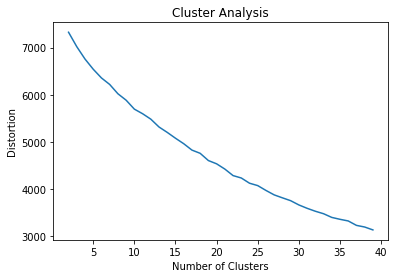

[7326.355552009711,
 7020.374967016055,
 6758.264242421535,
 6542.278144532352,
 6357.090171621356,
 6219.503829444963]

In [0]:
plot_clusters(num_clusters, ssws41)
ssws41[0:6]

Do you see a clear "elbow" in this graph??

Probably not.

Just so we can test your solution, we will mathematically define elbow as:

$$\hat{k}_{SSW} = \underset{k}{\operatorname{argmin}} (SS_W(k) - SS_W(k+1))$$

This is not a perfect mathematical definition because it does not take into account how much $SS_W$ dropped before the selected point. But for this dataset, it does provide one consistent answer.

In the cell below, complete the function that implements this mathematical definition. Note that we only pass in the list of distortion values. 

**So the function should return the index of the selected number of clusters!!**

Look at the visible test for this subsection to see how we ultimately assign the value of $k$.

In [0]:
# answer 4.2
# TODO: Complete the function
def sharpest(distortions):
    temp_list = []
    count = 1
    for value in range(0,len(distortions)):
       if value < 37:
           k = distortions[value] - distortions[count]
           count += 1
           temp_list.append(k)
           
    index = temp_list.index(min(temp_list))       
    print(index)
    return index

In [0]:
khat42 = num_clusters[sharpest(ssws41)]
print("I have chosen to have", khat42, "clusters.")
if ((khat42 < 2) or (khat42 > 39)):
    raise ValueError('k hat is not in the right range')

33
I have chosen to have 35 clusters.


### Step 4.3: The Variance Ratio Criterion

Perhaps we can shift to a different cluster evaluation metric that gives a more satisfying suggestion for the number of clusters.

Recall the Variance Ratio Criterion ($VRC$), given by

$$ VRC(k) = \frac{SS_B}{k-1} / \frac{SS_W}{N - k}$$

where $SS_B$ is the sum of squared distance between the cluster centers and the grand mean (calculated per data point), $k$ is the number of clusters, $SS_W$ is the sum of squared distance between data points and their assigned cluster centers, and $N$ is the number of data points.

#### Step 4.3.0: The grand mean

Before we apply the full formula, please compute the grand mean of the dataset. What does this represent?


In [0]:
# answer 4.3.0
# TODO: Compute grand_mean
# TODO #
grand_mean = np.mean(X, axis = 0)

#### Step 4.3.1: Interpret the grand mean

The grand mean is the text of the "average" review on Amazon. Let's figure out what that is a bit more precisely for this dataset. The function below finds real data points, i.e. real reviews, that are the closest neighbors to a given vector (`item`). `X_proj` is the dataset, `mask` is a list of booleans stating whether each item in the dataset is an eligible neighbor (we need this later), and `k` is the number of neighbors we would like to find. Write the missing code which should:

1. Normalize `item` by its Frobenius norm.
2. Loop through the dataset. Exclude the items that have a corresponding `False` value in `mask`.
3. For each eligible item in the dataset, compute the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) with `item`. Remember that you have normalized `item` but you will still need to normalize the other vector. 
4. Store the cosines in a list. It may be useful to put the cosines in tuples with the corresponding indices, but you don't have to do it this way.
5. Find the `k` highest cosine values.
6. Return the indices corresponding to these highest cosines. 

In [0]:
# answer 4.3.1
# TODO: Complete the function
def k_nearest_neighbors(X_proj, mask, item, k):
    normalized_item = np.linalg.norm(item)
    normalized = item/normalized_item
    temp_list = []
    for index, value in enumerate(X_proj):
        if mask[index] == True:
            normalized_data = np.linalg.norm(value)
            if normalized_data >= 0.01:
                value = value/normalized_data
            dot = np.dot(value, normalized)
            temp_list.append((index,dot))

    
    highest_vals = sorted(temp_list, reverse=True, key = itemgetter(1))[:k]
    indices = []
    
    for index, value in highest_vals:
       indices.append(index)
    
    return indices

This visible test prints the "readable" versions of the ten nearest neighbors to the grand mean review using `translate_review` from Step 0.2. Do you agree that these are acceptable "average" reviews?

In [0]:
most_typical_indices = k_nearest_neighbors(X, [True]*len(X), grand_mean, 10)
most_typical_reviews = lookup_docs(reviews_bow, most_typical_indices)
for review in most_typical_reviews:
    print(translate_review(review, reviews_dict))

away design good just just bought even need though grass buy went soon becom seed pot soil 
also design good littl much tri will one recommend work fine get month piec still take can exactli like like probabl product size larger buy buy look find happi big question allow rather keep new seem claim claim due parent alway natur serious singl later fabric far certainli awesom coupl practic common medic medic bit move prevent advertis yet room scienc inde fold hip tight movement wee steep growth cozi nowaday wacki dysplasia cuddli disloc disloc burrito swaddler kiddo 
great just just just know one reason go get well got got got like never less wonder given select credit bother pro pro shop hat bass bass 
also away come good good great just mix sorri think will will will will amazon bought ok one one price price anyth go goe enough fine fine first get get get stop stop stop take well around around around can can can cost like line per per per per even product see size cover soft way deal sa

#### Step 4.3.2 Implement VRC

Complete the function `test_vrc(data, max_num_clusters)` that computes the $VRC$ for each value of k in `num_clusters`. Since we are passing in the data, compute a new grand mean within the function. However, since the grand mean does not depend on the clusters, you should not compute it within a loop. Please compute $SS_B$ using the grand mean, the cluster centers, and the assignments only (no additional libraries or built-in values). Just as a warning, it is expected that your $SS_W$ and $SS_B$ may not add up to exactly the same number every time, but the sum should not change too much.

Additionally, please also compute a related ratio: 

$$\eta^2 = \frac{SS_B}{SS_B + SS_W}$$ 

This $\eta^2$ (eta squared) is an effect size that pairs with your $VRC$ statistic. Basically all of the $VRC$s are statistically significant because we have so many data points. This is why the effect size is so important. The literature recommends an effect size of at least 0.12.

The return statement is given because we would like to keep the $VRC$s and the $\eta^2$s.

In [0]:
# answer 4.3.2
# TODO: Complete the function
def test_vrc(data, num_clusters):
    vrcs = []
    etas_squared = []
    grand_mean = np.mean(X, axis = 0)
    for i in num_clusters:
        km = KMeans(n_clusters=i, init='k-means++', n_init=30, 
                    tol=1e-4, random_state=1911, n_jobs=1)
        km.fit(data)
        
        labels = km.labels_
        ss_between = 0
        
        #check which cluster each point falls into
        #for each point caculate distance from each cluster center to grand mean 
        #sum distance up
        
        for value in labels:
            distance = np.linalg.norm(km.cluster_centers_[value]- grand_mean)**2
            #print(distance)
            ss_between += distance

        vrc = (ss_between/(i-1)) / ((km.inertia_)/(len(X)-i))
        vrcs.append(vrc.item())
        etas = ss_between / (ss_between + km.inertia_)
        etas_squared.append(etas.item())
        
        #print(labels)
        #print(km.cluster_centers_)
        
        print(i, km.inertia_, vrcs, etas_squared)

    return vrcs, etas_squared

The code below takes a while to run just as the normal clustering before. I recommend printing the $VRC$ and $\eta^2$ values as the come, so that you can track the progress.

In [0]:
num_clusters = range(2,40)
vrcs432, etas_squared432 = test_vrc(X, num_clusters)

2 7326.341158202441 [4609.467741273722] [0.04406442332276263]
3 7018.166160134202 [4609.467741273722, 4600.168074962583] [0.04406442332276263, 0.0842542178619938]
4 6758.138264414306 [4609.467741273722, 4600.168074962583, 4468.024491285873] [0.04406442332276263, 0.0842542178619938, 0.11820162953375594]
5 6538.929611508317 [4609.467741273722, 4600.168074962583, 4468.024491285873, 4300.297841460727] [0.04406442332276263, 0.0842542178619938, 0.11820162953375594, 0.1467726140702575]
6 6348.48533072781 [4609.467741273722, 4600.168074962583, 4468.024491285873, 4300.297841460727, 4144.129613868802] [0.04406442332276263, 0.0842542178619938, 0.11820162953375594, 0.1467726140702575, 0.1716498237847748]
7 6170.869719856088 [4609.467741273722, 4600.168074962583, 4468.024491285873, 4300.297841460727, 4144.129613868802, 4032.935647712122] [0.04406442332276263, 0.0842542178619938, 0.11820162953375594, 0.1467726140702575, 0.1716498237847748, 0.19484253382008113]
8 5999.67652357285 [4609.467741273722, 

In [0]:
## AUTOGRADER Step 4.3.2.1: Run this to get your score. ##
print(vrcs432)
print(etas_squared432)
grader.grade(question_id = "4.3.2.1", answer = (vrcs432, etas_squared432))

[4609.467741273722, 4600.168074962583, 4468.024491285873, 4300.297841460727, 4144.129613868802, 4032.935647712122, 3961.715558711587, 3904.3159479461983, 3871.1849249869024, 3858.064256551141, 3755.671620325887, 3744.626927331037, 3751.4471303897703, 3785.3574026684632, 3742.805895785077, 3725.4759889980223, 3706.111215992465, 3700.7751317662596, 3686.011016316218, 3759.702718354393, 3759.186914138205, 3777.4501131261613, 3782.5034066839057, 3761.0586639690478, 3803.67122364385, 3823.876724436386, 3831.5628384661545, 3783.9454277062664, 3832.5268712111024, 3888.7719774074694, 3891.894445725496, 3877.277577657188, 3842.0227212636637, 3917.404506199528, 3837.0649231660636, 3841.054804186153, 3843.695731147388, 3805.513455731372]
[0.04406442332276263, 0.0842542178619938, 0.11820162953375594, 0.1467726140702575, 0.1716498237847748, 0.19484253382008113, 0.2171244791596644, 0.23802173371852675, 0.2584031199381438, 0.27842059668496066, 0.2923727843915317, 0.3100658348895331, 0.327846957093336

#### Step 4.3.3: Select a number of clusters with VRC

The code below prints rounded versions of the $VRC$s and $\eta^2$s. Then, it plots the number of clusters (from 2 to 40) versus $VRC$. You do not need to modify this cell.

 2 4609 0.04
 3 4600 0.08
 4 4468 0.12
 5 4300 0.15
 6 4144 0.17
 7 4033 0.19
 8 3962 0.22
 9 3904 0.24
10 3871 0.26
11 3858 0.28
12 3756 0.29
13 3745 0.31
14 3751 0.33
15 3785 0.35
16 3743 0.36
17 3725 0.37
18 3706 0.39
19 3701 0.4
20 3686 0.41
21 3760 0.43
22 3759 0.44
23 3777 0.45
24 3783 0.47
25 3761 0.47
26 3804 0.49
27 3824 0.5
28 3832 0.51
29 3784 0.51
30 3833 0.53
31 3889 0.54
32 3892 0.55
33 3877 0.55
34 3842 0.56
35 3917 0.57
36 3837 0.57
37 3841 0.58
38 3844 0.59
39 3806 0.59


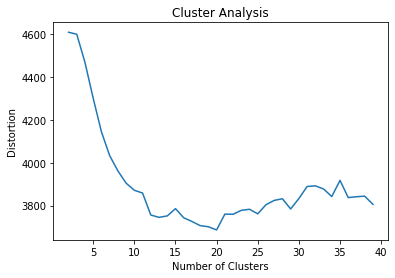

In [0]:
for i in range(len(num_clusters)):
    print("%2d"%num_clusters[i], 
          "%d"%np.round(vrcs432[i], 0), 
          np.round(etas_squared432[i], 2))

plot_clusters(num_clusters, vrcs432)

Much better, right??

Complete the `best_vrc` function that compares and chooses a number of clusters based on the $VRC$s and $\eta^2$s. Note that you are now looking for local maxima, so your elbow method should not be used again. Let's define a maximum as a point where the graph is increasing just before and decreasing just after. Return a list of all indices of `distortions` that are maxima. Then, these can be used to select $k$s from the `num_clusters` array.

In [0]:
# answer 4.3.3
# TODO: Complete the function
def best_vrc(distortions):
    maxima = []
    count = 0
    for index, value in enumerate(distortions):
      
      if index < (len(distortions)-1) and index >= 1:
        print(distortions[index-1])

        if distortions[index-1] < value and distortions[index + 1] < value:
          maxima.append(index)

    print(maxima)
    return maxima

In [0]:
khat433 = [num_clusters[i] for i in best_vrc(vrcs432)]
print("A good number of clusters is one of these:", khat433)
if ((min(khat433) < 2) or (max(khat433) > 39)):
    raise ValueError('k hat is not in the right range')

4609.467741273722
4600.168074962583
4468.024491285873
4300.297841460727
4144.129613868802
4032.935647712122
3961.715558711587
3904.3159479461983
3871.1849249869024
3858.064256551141
3755.671620325887
3744.626927331037
3751.4471303897703
3785.3574026684632
3742.805895785077
3725.4759889980223
3706.111215992465
3700.7751317662596
3686.011016316218
3759.702718354393
3759.186914138205
3777.4501131261613
3782.5034066839057
3761.0586639690478
3803.67122364385
3823.876724436386
3831.5628384661545
3783.9454277062664
3832.5268712111024
3888.7719774074694
3891.894445725496
3877.277577657188
3842.0227212636637
3917.404506199528
3837.0649231660636
3841.054804186153
[13, 19, 22, 26, 30, 33, 36]
A good number of clusters is one of these: [15, 21, 24, 28, 32, 35, 38]


## Step 5: t-SNE

In this last section, we are going to create a t-SNE plot that may help us decide how to use the clusters that we found in the previous section. More specifically, does k-means find differences between the reviews that are related to the star ratings, or other differences?

We are going to use the clustering given below for this section. Double check that `X` is still the same as when you defined it in Step 4.0. You do not need to modify the cell.

In [0]:
km = KMeans(n_clusters=35, init='k-means++', n_init=30, max_iter=10, 
            tol=1e-4, random_state=1911, n_jobs=1)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=35, n_init=30, n_jobs=1, precompute_distances='auto',
       random_state=1911, tol=0.0001, verbose=0)

### Step 5.1: Exemplars of each cluster

Let's begin by approaching this question in a somewhat qualitative way. Namely, let's find the nearest review to each cluster center. Complete the function below that iterates through the cluster centers of `km`. For each cluster center, call `k_nearest_neighbors`. Use the cluster assignments (labels) from `km` to construct the `mask` parameter for `k_nearest_neighbors`. The key idea here is that you want to search only through the reviews that were assigned to that cluster when searching for neighbors. It really should not change your answer, but it is a whole lot faster to do it this way. Alternatively, you could subset the dataset and pass in `[True]*(number_of_points_in_that_cluster)` as the mask, i.e. the mask has all true values, so no item is masked. But keeping track of indices is harder in that case.

The function should return a list of lists of indices. There is one list per cluster center. Each index in one of these lists corresponds to a closest neighbor to a cluster center.

In [0]:
# answer 5.1
# TODO: Complete the function
def get_exemplars(X_proj, km, n_exemplars):
    examplar_indicies = []
    for index, center in enumerate(km.cluster_centers_):
        mask_list = []

        for value in km.labels_:
            if index == value:
                mask = True
                mask_list.append(mask)
            else:
              mask = False
              mask_list.append(mask)
        
        return_list = k_nearest_neighbors(X_proj,mask_list,center,n_exemplars)
        examplar_indicies.append(return_list)

    return examplar_indicies
    
    #examplar_indicies.append(mask_list)

The visible test cell below finds the indices of the nearest neighbors to each cluster center. Then it looks up the vectors for each of these indices and prints the readable version of each vector. Depending on your implementation this cell could take a long time. You do not need to modify this cell.

In [0]:
exemplar_indices = get_exemplars(X, km, 1)
exemplars = lookup_docs(reviews_bow, sum(exemplar_indices, []))
for exemplar in exemplars:
    print(translate_review(exemplar, reviews_dict))

favorit just just took dog dog know put horribl get piec stop well give made like thing year break near small found bigger eat buy compani happen love treat treat treat mind risk whenev china china chihuahua ate peac similiar 
also also destroy good hard littl money toy dog worth one one recommend review go get chew chew chew can end got like suppos thing cut nylabon german shepherd find bone durabl vet half lot love rather addit definit differ quickli teeth teeth teeth dog' mention note sharp broken broken spend edg front adult bunch gum tooth softer gsd jag chip occur 
better better good great mix dog dog dog put reason make tend around probabl year leg found smaller purchas possibl howev seem old fact leav seizur control idea idea hous experi option solut medic separ wrap anxieti anxieti 65lb thundershirt 
also also apart better design great great great great insid just littl much much much much much much think tri will will will clean clean day dump put sinc sinc sinc use use use u

### Step 5.2: Prepare and run t-SNE

The core idea of t-SNE is preserving the relative distances between all of the data points, but showing those distances in very few dimensions. As such, t-SNE compares every data point against every data point (Cartesian product). For the full dataset, that would be about 19 billion comparisons. So we can't do that.

But, fortunately, you have already done a lot of work to cluster these data points. If we take a relatively large number of clusters and only consider 30 or so exemplars from each cluster, that should be small enough for t-SNE. The code below assembles the data subset for t-SNE using functions you have written before. Depending on your implementation this cell could take a long time. You do not need to modify this cell.

In [0]:
exemplar_indices = get_exemplars(X, km, 30)
exemplars = lookup_docs(reviews_tfidf, sum(exemplar_indices, []))
for_tsne = densify(exemplars, len(reviews_dict))
for_tsne.shape

(1050, 18716)

The hyperparameters for t-SNE that I used to get a pretty picture are given below. All you need to do is look up the command to train the t-SNE model, which is given in the [API](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Call your t-SNE vectors `embeddings_2d`.

In [0]:
# answer 5.2
# TODO: Run t-SNE
tsne_model_2d = TSNE(perplexity=20, n_components=2, init='pca', n_iter=3500, random_state=1911)
embeddings_2d = tsne_model_2d.fit_transform(for_tsne)
print(embeddings_2d)

[[-38.127148   -27.795916  ]
 [-28.596403   -11.88707   ]
 [-38.129326   -27.823748  ]
 ...
 [-13.8688965   -8.404951  ]
 [ 42.503136    33.078354  ]
 [  7.4058647   -0.12187579]]


### Step 5.3: Color the points

Some code to plot the t-SNE vectors is given below, but it won't look very pretty yet because we have not decided on a color scheme for the points. We will implement two options.

In [0]:
def tsne_plot(embedding_clusters, a):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(embedding_clusters)))
    for embeddings, color in zip(embedding_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color]*len(x), alpha=a)
    plt.show()

#### Step 5.3.1: By cluster membership

The most straighforward choice would be to color a point according to the k-means cluster to which it was assigned. k-means is based on Euclidean distance and t-SNE is based on angular distance, so there should be some, but not total, consistency between the two algorithms.

`get_exemplars` originally had a list of lists of indices, but these had to be flattened for `lookup_docs`. Therefore, you just need to re-group the points into clusters. There are exactly 30 points in each cluster, so there are many ways to do this. If you want an extra challenge, you can solve this part without using the magic number 30. But it is not required and will not affect your homework score.

Call the re-grouped t-SNE vectors `embeddings`.

In [0]:
# answer 5.3.1
# TODO: group the t-SNE embeddings by cluster membership
embeddings = []
embeddings = np.array_split(embeddings_2d, 35, axis = 0)

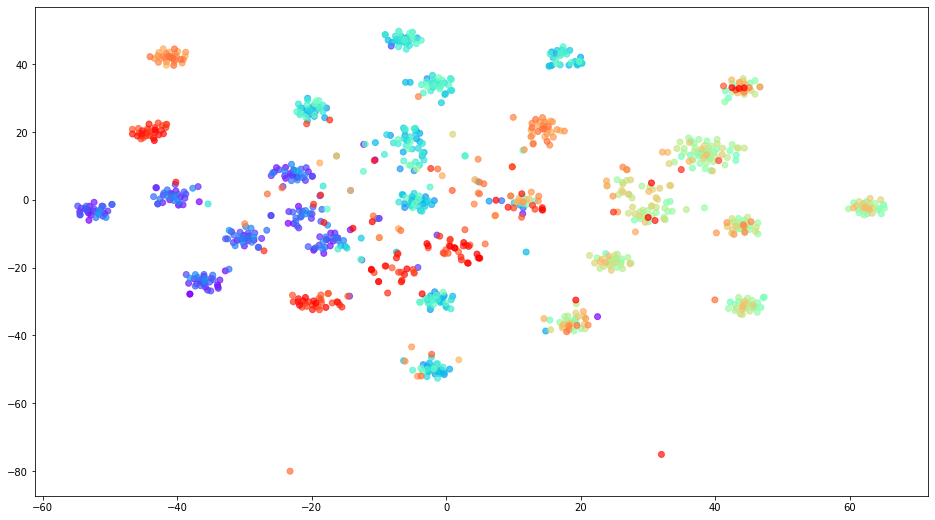

In [0]:
tsne_plot(embeddings, 0.7)

#### Step 5.3.2 By star rating

Now as a finale, group the reviews by star rating. When you are done, `embeddings` should have a length of five. Then, redraw the plot.

In [0]:
# answer 5.3.2
# TODO: group the t-SNE embeddings by star rating
embeddings = [[],[],[],[],[]]
temp_list = []

#get the indices of the start ratings that are subsetted
for index in exemplar_indices:
    temp_list.append(y[index])
#print(len(temp_list))

#make the array of arrays with point data 35 arrays of length 30
temp_embeddings = np.array_split(embeddings_2d, 35, axis = 0)

#sort array of array into star-rating buckets
for index, list_of_ratings in enumerate(temp_list):
  #print('index', index)
  for i, rating_in_list in enumerate(list_of_ratings):
      #print('rating',i)
      if rating_in_list == 1:
          #print('rating in list = 1')
          #print(temp_embeddings[index][i])
          temp_item = temp_embeddings[index][i]
          embeddings[0].append(temp_item)
          #print(embeddings[0])
      elif rating_in_list == 2:
          temp_item = temp_embeddings[index][i]
          embeddings[1].append(temp_item)
      elif rating_in_list == 3:
          temp_item = temp_embeddings[index][i]
          embeddings[2].append(temp_item)
      elif rating_in_list == 4:
          temp_item = temp_embeddings[index][i]
          embeddings[3].append(temp_item)
      else:
          temp_item = temp_embeddings[index][i]
          embeddings[4].append(temp_item)

embeddings[0]= np.vstack(embeddings[0])
embeddings[1]= np.vstack(embeddings[1])
embeddings[2]= np.vstack(embeddings[2])
embeddings[3]= np.vstack(embeddings[3])
embeddings[4]= np.vstack(embeddings[4])

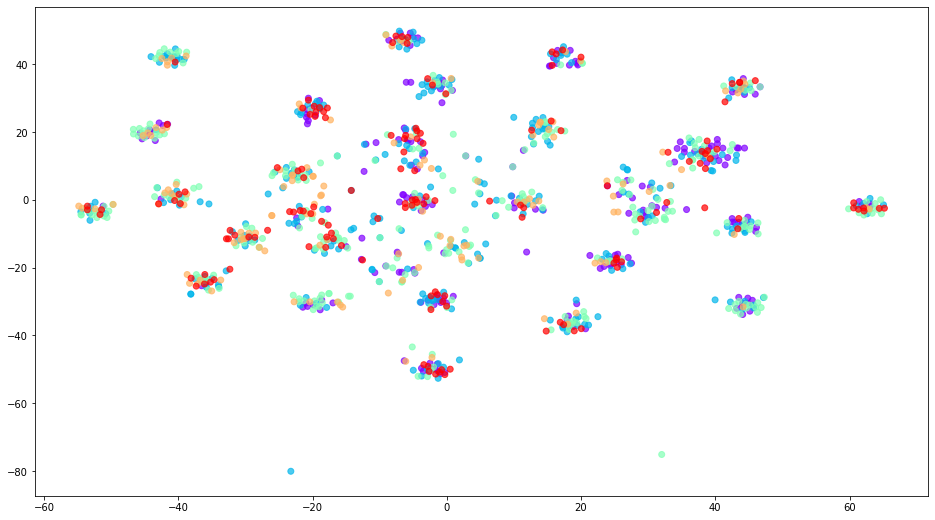

In [0]:
tsne_plot(embeddings, 0.7)

As you can see, the clusters formed by k-means and t-SNE do not seem to correspond to the star ratings. This pretty, but somewhat unhappy standpoint is where Homework 4 ends and your project begins.

What kinds of analyses have we not tried? What structure is still hidden in these reviews? Can you infer how these 100,000 reviews were selected? Can something fancier than a random forest have higher accuracy in predicting the star rating?

For your project, your task is to put together an interesting notebook about this dataset, similar to this one, the other homework notebooks from this class, or articles on [towardsdatascience.com](https://towardsdatascience.com/). The notebook should explain what you did in such a way that a non-technical person can read it. As such, your project will be manually graded as a work of data science communication. We hope that you can use your project notebook as something that you can show off in data science job interviews and the like. 

Congratulations on all of your work so far! Five stars for you!